In [8]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

import seaborn as sns
import os


from scipy.stats import gaussian_kde
# Depending on the machine on which the code is run, data might be stored in different directories.
# Indicate which machine is used to make sure the path to the data can be found.
# Can either be "local" or "Snellius"

sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')

MACHINE = 'local'

if MACHINE == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/' # used for storing the trained model

    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/' # used for storing the trained model

    pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/' # For storing and retrieving my own data files

elif MACHINE == 'local':
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = './models/' # used for storing the trained model

    SF_DIR = './fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'

    pers_file_dir = './data_files/' # For storing and retrieving my own data files



SARIMA_params = {'order': (2,0,2),             # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c'                  # Adding an intercept term
                 }

# if machine == 'snellius':
#     regionsfile = '/gpfs/home5/awoude/Ritten/EKF/regions.nc' # Contains the data on the distribution of ecoregions
# elif machine == 'local':
#     regionsfile = './data_files/regions.nc' # Contains the data on the distribution of ecoregions

# Code for generating figures Part II
The following notebooks generates most of the figures used within Part II of the thesis. Only Figure 9.2 is missing as this figures required turing the `base_model.plot_fit()` function, but more on this later. Other figures are generated in other notebooks, and cannot be taken out of this context. When this is the case, a direct reference to the needed notebook is provided.

## Figure 7.1-7.3
These plots are generated in a jupyter notebook which is currently still located on Snellius. Still needs to be recovered


In [ ]:
def get_state_vec(f, state_elem_ds):
    with xr.open_dataset(f) as ds:
        sf_total  = ds['flux_multiplier_m']
        # combined dataset in which the elements of the state vector and the scaling vectors are aligned based on longitude and latitude
        comb = state_elem_ds.merge(sf_total)
        print(comb)
        gr = comb.groupby('regions').max()['flux_multiplier_m'] # All values should be the same, so taking the max or min should not make a difference
        return gr

def count(list1, l, r):

    # Traversing the list with on line for loop
    # check if number is in range of not
    return sum( l <= x <= r for x in list1)

In [ ]:
file_name = 'weekly_sv.nc'
file_path = pers_file_dir + file_name
if os.path.exists(file_path):
    with xr.open_dataset(file_path) as ds:
        ds = ds.rename_vars({"flux_multiplier_m": "sf"})
        # ds = ds.to_dataset()
        weekly_sv = ds

In [ ]:
print(weekly_sv.sf.values)
fig = plt.figure()
fig.set_size_inches(6, 4)
ax = fig.add_subplot(1, 1, 1)


data = weekly_sv.sf.values.flatten()
ratio_in_range = count(data, 0, 3)/len(data)
hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # For some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/Hist_sf.pdf')
plt.show()

print(f'Ratio in range: {ratio_in_range}')

## 7.2
Gridded vs. non-gridded

In [ ]:
with xr.open_dataset(state_vec_file) as ds:
#     print(ds)
    state_vec = ds[['regions', 'transcom_regions']]
    state_vec = state_vec.rename({'longitude':'lon', 'latitude':'lat'})

file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    eco_regions = ds.regions
    eco_regions = eco_regions.rename('eco_regions')


# Define which transcomregions should be included in the optimisation process.
gridded_trans_regions = {'North American Boreal': 1,
                          'North American Temperate': 2,
                          'Eurasia Boreal': 7,
                          'Eurasia Temperate': 8,
                          'Europe': 11}


region_ds = xr.merge([state_vec,eco_regions])
trans_filter = [name in gridded_trans_regions.values() for name in np.unique(region_ds.transcom_regions)]
gridded_sv_elems = {}
non_gridded_sv_elems = {}

# item in test_list for item in test_list

for r in np.unique(region_ds.transcom_regions.values):
    sv_elems = np.unique(region_ds.where(region_ds.transcom_regions==r).regions.values)
    sv_elems = sv_elems[~np.isnan(sv_elems)]
    if (r in gridded_trans_regions.values()):
        gridded_sv_elems[r] = sv_elems
    else:
        non_gridded_sv_elems[r] = sv_elems

list_gridded_elems = np.concatenate(list(gridded_sv_elems.values())).flat
list_non_gridded_elems = np.concatenate(list(non_gridded_sv_elems.values())).flat

print(len(list_gridded_elems))
print(len(list_non_gridded_elems))

In [ ]:
from matplotlib.patches import Rectangle

print(weekly_sv.sf.values)
fig = plt.figure()
fig.set_size_inches(6, 4)
ax = fig.add_subplot(2, 1, 1)
data = weekly_sv.sel(regions = list_gridded_elems).sf.values.flatten()
gridded_ratio_in_range = count(data, 0, 3)/len(data)
hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
# plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Gridded statevector elements',fontweight="bold")
plt.tight_layout()

ax = fig.add_subplot(2, 1, 2)


data = weekly_sv.sel(regions = list_non_gridded_elems).sf.values.flatten()
non_gridded_ratio_in_range = count(data, 0, 3)/len(data)

hist = ax.hist(data, bins=80, range=[-9, 11])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')
        #hist[2][i].set_alpha(0.5)
    #else:
        #hist[2][i].set_facecolor('C0')
        #hist[2][i].set_alpha(0.5)
# L = ax.legend(*hist.legend_elements(),
#                     loc="upper left", title="TC_region")
# #ax.set_xscale('log')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')

plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Non-gridded statevector elements',fontweight="bold")
plt.tight_layout()

plt.savefig('../figures/Hist_sf_gid_vs_non-grid.pdf')

plt.show()

print(f'Ratio in range gridded: {gridded_ratio_in_range}')
print(f'Ratio in range non-gridded: {non_gridded_ratio_in_range}')

## 7.3
Resulting distribution

In [ ]:
file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    weekly_sf_eco = ds.sf_per_eco

print(weekly_sf_eco.values)
fig = plt.figure()
fig.set_size_inches(6, 4)

ax = fig.add_subplot(2, 1, 1)
data = weekly_sv.sel(regions = list_gridded_elems)
hist = ax.hist(data.sf.values.flatten(), bins=84, range=[-20, 22])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
labels= ["Plausible values","Implausible values"]
plt.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
plt.axvline(x=3.25, color='b', alpha=0.5, linestyle='--')
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles.append(handles)
new_labels.append(labels)
print(handles)
plt.legend(new_handles, new_labels)
plt.ylabel('Frequency')
plt.title('Gridded statevector elements',fontweight="bold")
plt.tight_layout()

ax = fig.add_subplot(2, 1, 2)

data = weekly_sf_eco.values.flatten()
eff_sf_ratio_in_range = count(data, 0, 3)/len(data)
hist = ax.hist(data, bins=84, range=[-20, 22])

for i in range(len(hist[0])):
    if (hist[1][i] < 0) or (hist[1][i] > 3):
        hist[2][i].set_facecolor('C3')

plt.xlabel('Scaling factor')
plt.ylabel('Frequency')
plt.title('Effective scalingfactor elements',fontweight="bold")
plt.tight_layout()
plt.savefig('../figures/Hist_grid_vs_eff.pdf')
plt.show()


print(f'Ratio in range gridded: {gridded_ratio_in_range}')
print(f'Ratio in range effective_sf: {eff_sf_ratio_in_range}')

## Figure 7.4

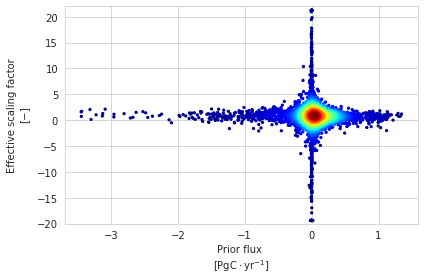

In [3]:
with xr.open_dataset('./data_files/vars_per_eco_update.nc') as ds:
    remaining_vars = ds[[
                    'prior_flux_per_s', 'sf_per_eco']]

fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr

x = remaining_vars.prior_flux_per_s.isel(time=slice(0,52)).values.flatten()*fac
y = remaining_vars.sf_per_eco.isel(time=slice(0,52)).values.flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, cmap='jet')

ax.set_ylim(-20, 22)
ax.set_ylabel('Effective scaling factor\n'r'[$-$]')
ax.set_xlabel('Prior flux \n'r'[$\mathrm{PgC\cdot yr^{-1}}$]')
plt.tight_layout()
plt.savefig('../figures/corr_prior_esf.pdf')
plt.show()

## 7.5
Effective scaling facter per TransCom region

In [ ]:
continent_dict = {0:'North American Boreal',
                   1:'North American Temperate',
                   2:'South American Tropical',
                   3:'South American Temperate',
                   4:'Northern Africa',
                   5:'Southern Africa',
                   6:'Eurasia Boreal',
                   7:'Eurasia Temperate',
                   8:'Tropical Asia',
                   9:'Australia',
                   10:'Europe',
                   11:'Seven seas (open ocean)',
                   12:'Not optimized',
                   13:'Out of bounds'
                  }

file = pred_var_path+'vars_per_eco_update.nc'

with xr.open_dataset(file) as ds:
    weekly_sf_eco = ds.sf_per_eco
#     weekly_sf_eco = weekly_sv.rename({'regions':"eco_regions"}).sf
transcom_region = ((weekly_sf_eco.eco_regions-1)/19).astype(int)
transcom_region = transcom_region.rename('transcom_region')

comb_ds = xr.merge([transcom_region, weekly_sf_eco])

grouped = comb_ds.groupby('transcom_region')
fig, axes = plt.subplots(5,2, sharex=True, figsize=(9,8))

for i, group in enumerate(grouped.groups.keys()):
    print(group)
    ax_raw = axes[i][0]
    ax_eff = axes[i][1]
#     if use_eff_sf:
    data_eff_sf = grouped[group].sf_per_eco.values.flatten()
#     else:
    data_raw_sv = weekly_sv.sel(regions=gridded_sv_elems[int(group)+1]).sf.values.flatten()
    for data, ax, aggr_meth in zip([data_raw_sv, data_eff_sf], [ax_raw, ax_eff], ['raw', 'effective']):
        hist = ax.hist(data, bins=84, range=[-20, 22])
        ax.set_title(continent_dict[group], style='italic')
        eff_sf_ratio_in_range = count(data, 0, 3)/len(data)
        print(f"ratio of realistic {aggr_meth} scaling factors of region {continent_dict[group]}: {eff_sf_ratio_in_range}")
        for i in range(len(hist[0])):
            if (hist[1][i] < 0) or (hist[1][i] >= 3):
                hist[2][i].set_facecolor('C3')


        ax.axvline(x=0.0, color='b', alpha=0.5, linestyle='--', label='Deliminer of plausible values')
        ax.axvline(x=3.0, color='b', alpha=0.5, linestyle='--')

for yax in axes:
    yax[0].set_ylabel('Frequency')
for xax in axes[4][:]:
    xax.set_xlabel('Scaling factor')

pad = 30 # in points

for ax, col_name in zip(axes[0], ['Original scaling factors', 'Effective scaling factors']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")


# handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['C0','C3']]
# labels= ["Plausible values","Implausible values"]
handles, labels = ax.get_legend_handles_labels() # Some some reason, old handles can no longer be included. Needs additional debuging
new_handles = [Rectangle((0,0),1,1,linewidth=0,color=c,ec="k") for c in ['C0','C3']]
new_labels = ["Plausible values","Implausible values"]
new_handles = np.concatenate([new_handles, handles])
new_labels = np.concatenate([new_labels, labels])

plt.tight_layout()
fig.subplots_adjust(bottom=0.12, top=0.9)   ##  Need to play with this number to make column names and legend fit.

fig.legend(new_handles, new_labels, loc="lower center", ncol=3)

plt.savefig('../figures/Hist_grid_vs_eff_eco.pdf')
plt.show()

## 9.1 (and also figures B.4 to B.7)

In [13]:

def mol_per_sec_to_PgC_per_year(df):
    fac= 86400.*365.*12./1e15 # from mol/s to PgC/yr
    for var in ['flux_ME_test', 'flux_ME_train', 'flux_MAE_test', 'flux_MAE_train', 'flux_RMSE_test', 'flux_RMSE_train']:
        df[var] = df[var]*fac
    return df


def load_results(model_name):
    file_name = RESULTS_DIR + model_name + '_results_per_tc.pkl'
    df = pd.read_pickle(file_name)
    df = mol_per_sec_to_PgC_per_year(df)
    return df.set_index(['N_train_years','tc_region'])

used_models = ['SARIMA', 'SARIMAX', 'monthly', 'prior']

results_dict = {model_name: load_results(model_name) for model_name in used_models}

results_df = pd.concat(results_dict)

results_df.index.rename(['model', *list(results_df.index.names)[1:]], inplace=True)


./results/SARIMA_results_per_tc.pkl
      start_year  N_train_years  N_train_obs  N_test_years  N_test_obs  \
1.0         2016              1           53             4         208   
1.0         2015              2          105             4         208   
1.0         2014              3          157             4         208   
1.0         2013              4          209             4         208   
1.0         2012              5          261             4         208   
...          ...            ...          ...           ...         ...   
11.0        2004             13          679             4         208   
11.0        2003             14          731             4         208   
11.0        2002             15          783             4         208   
11.0        2001             16          835             4         208   
11.0        2000             17          888             4         208   

      tc_region  sf_ME_train  sf_MAE_train  sf_MAPE_train  sf_RMSE_train  .

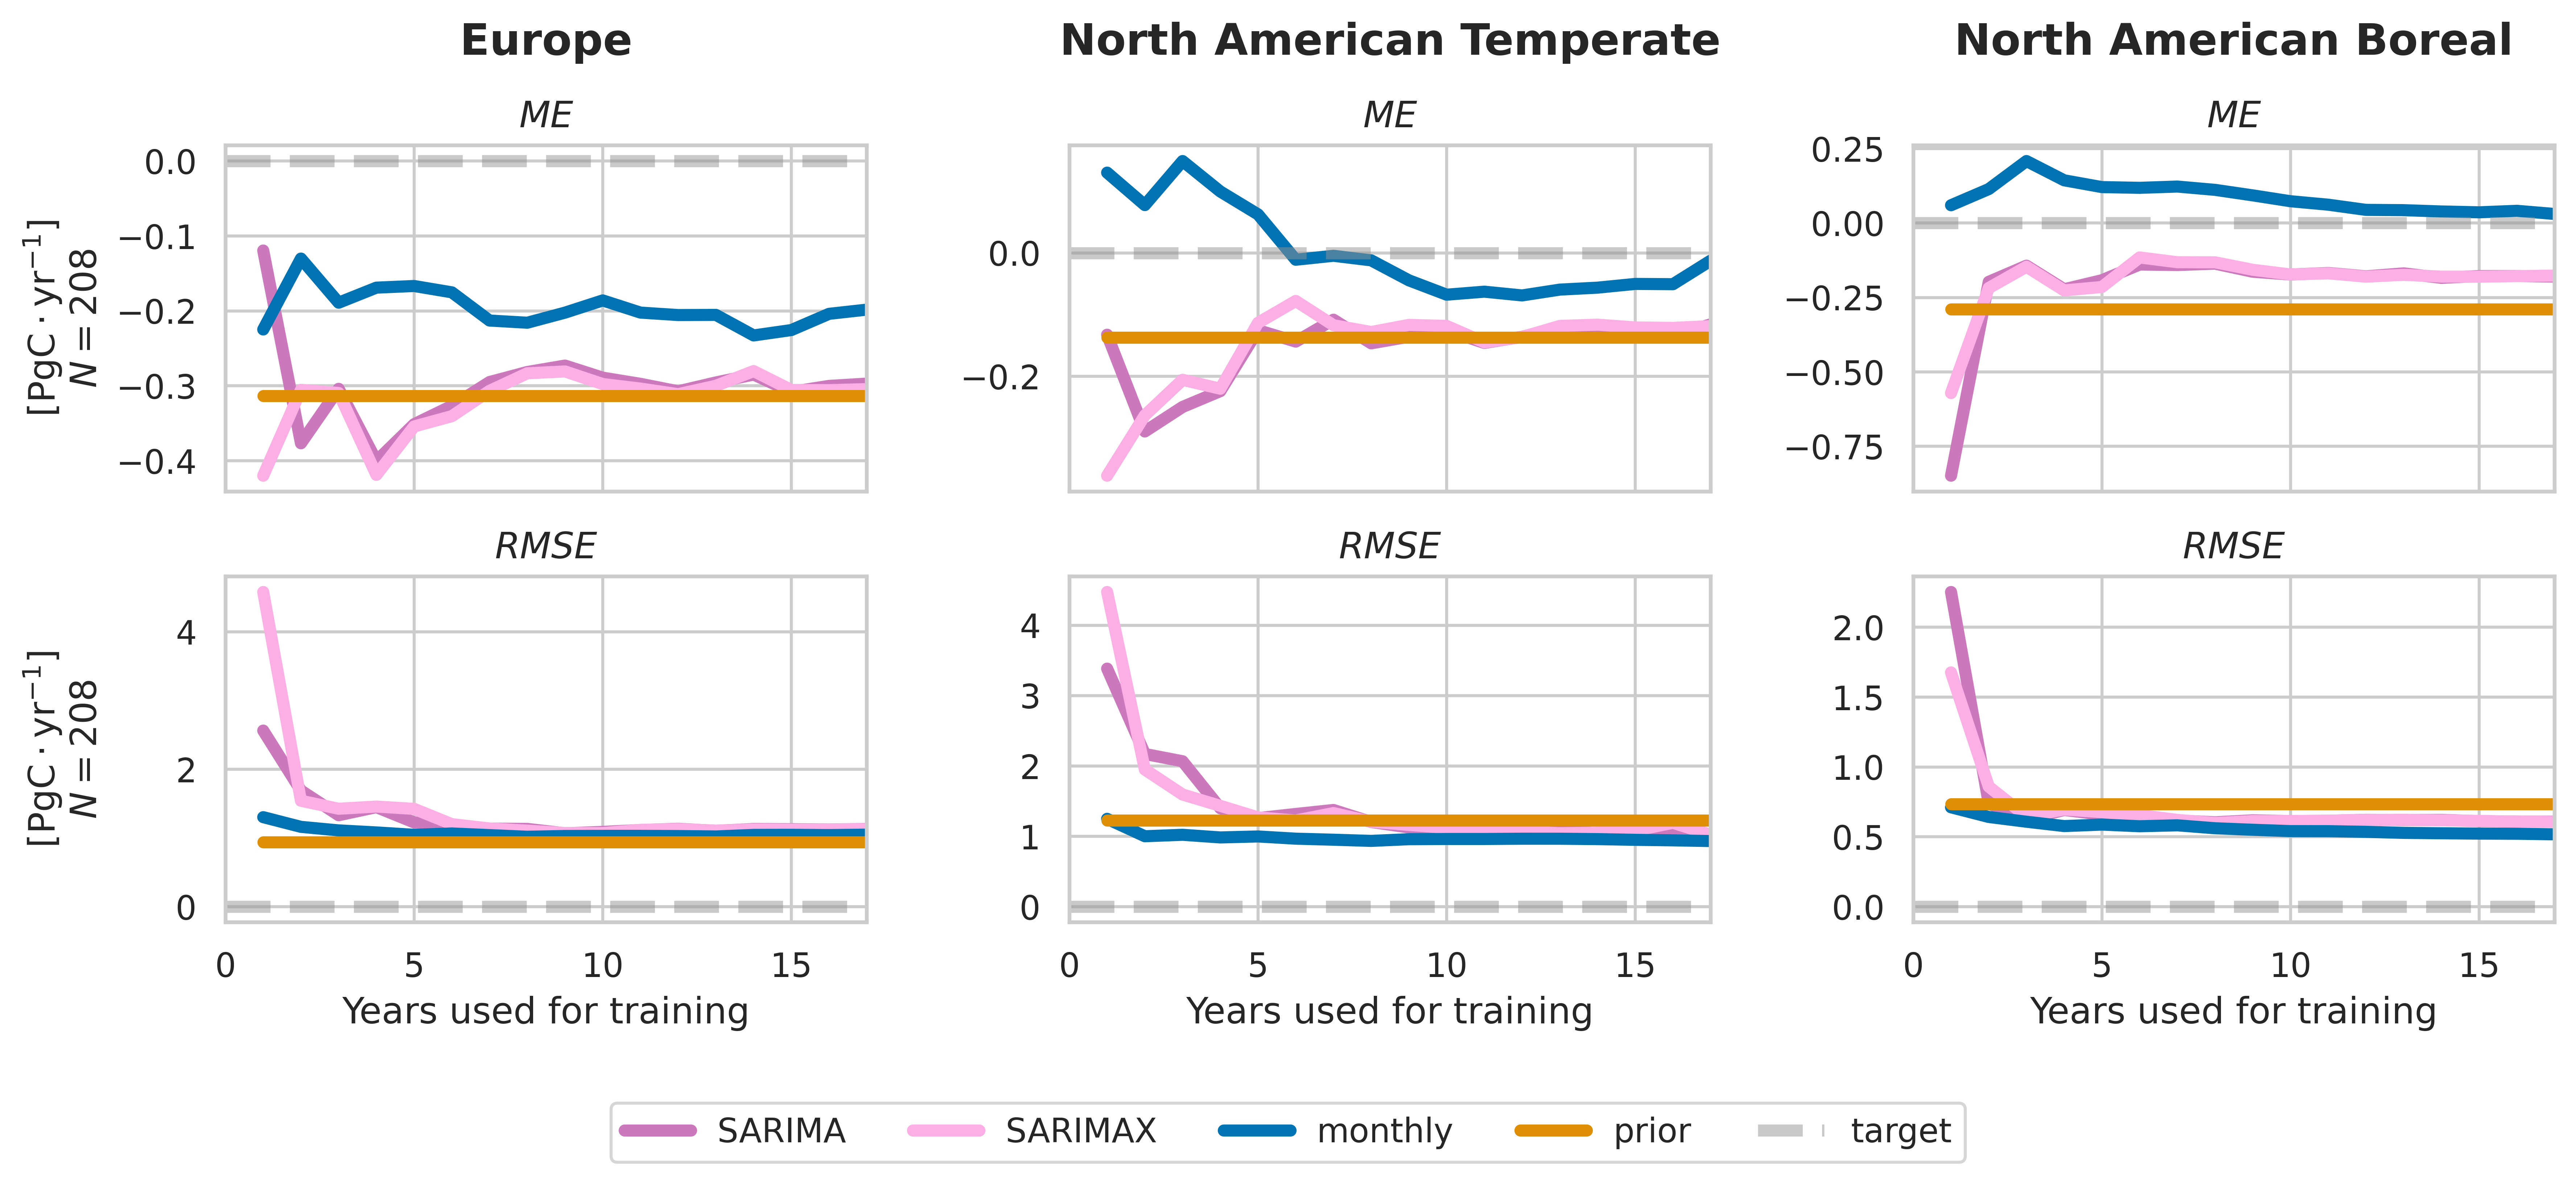

In [15]:
eval_space = 'flux' # options: 'flux' or 'sf

used_perf_measures = ['ME', 'RMSE'] # options: ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

tc_subset = [11.0, 2.0, 1.0] # options: [1.0, 2.0, 7.0, 8.0, 11.0]

tc_groups = results_df.groupby(['tc_region'])
tc_groups = {tc: tc_groups.get_group(tc) for tc in tc_subset}
tc_regions = list(tc_groups.keys())

# tc_regions = [2.0, 11.0] # meaning the north american temperate and europe transCom regions



N_term = '\n'+r'$N=208$'

y_labels = {'flux':{'ME':   r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'MAE':  r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'MAPE': '[%]'+N_term,
                    'RMSE': r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'r2':   '[-]'+N_term},
            'sf':{'ME':     '[-]'+N_term,
                  'MAE':    '[-]'+N_term,
                  'MAPE':   '[%]'+N_term,
                  'RMSE':   '[-]'+N_term,
                  'r2':     '[-]'+N_term}}

# Because the R^2 performance measure needs to be interpreted differently, a dictionary is introduced describing the target value of each performance measure
var_target = {'ME':     0,
              'MAE':    0,
              'MAPE':   0,
              'RMSE':   0,
              'r2':     1}


x_label = 'Years used for training'


#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')


plot_train = False
model_alpha_dict = {'prior':1, # alpha TC region 1
                   'CTE2018':1, # alpha TC region 2
                   'monthly':1, # alpha TC region 7
                   'SARIMA':1, # alpha TC region 8
                   'SARIMAX':1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
model_color_dict = {'prior':1,
                 'smoothed':2,
                 'monthly':0,
                 'SARIMA':4,
                 'SARIMAX':6}

color_indices = [model_color_dict[model] for model in used_models]

colors = [pal[c] for c in color_indices]

alphas = [model_alpha_dict[model] for model in used_models]

colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(tc_regions)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(n_cols*4,n_rows*2.5), sharex=True)

for j, (tc_region, tc_dat) in enumerate(tc_groups.items()):

    tc_dat.reset_index(inplace=True)
    tc_dat.set_index(['model', 'N_train_years'], inplace=True)
    for i, perf_mes in enumerate(used_perf_measures):
        tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linewidth = 4, sort_columns=True)

        if plot_train:
            tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':', linewidth = 2, sort_columns=True)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i, perf_mes in enumerate(used_perf_measures):
    ax[i][0].set_ylabel(y_labels[eval_space][perf_mes])
    for j in range(n_cols):
        ax[i][j].axhline(y=var_target[perf_mes], color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)

pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"


col_names = [continent_dict[int(tc_region)] for tc_region in tc_regions]
for axes, col_name in zip(ax[0], col_names):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")
for axes in ax[-1]:
    axes.set_xlabel(x_label)

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

len_legend = 2*len(used_models)+1 if plot_train else len(used_models)+1


handles = original_handles + [None] * (len_legend-len(original_handles))

if plot_train:
    # overly complicated method for determining the order in which the elements from the legend should be ordered, essentially 'zipping' two lists
    legend_order = sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(len(used_models)), range(len(used_models), len(used_models)*2))], [])
    legend_order = legend_order + [len_legend-1]

    train_labels = ['(train) ' + label for label in original_labels[len(used_models):len(used_models)*2]]

    test_labels = ['(test) ' + label for label in original_labels[:len(used_models)]]
    # labels = [label for label in test_labels for label in train_labels]
    labels = test_labels + train_labels + [original_labels[-1]]

    # reordering the labels and handles of the legend
    labels = [labels[idx] for idx in legend_order]
    handles = [handles[idx] for idx in legend_order]
else:
    labels = original_labels

plt.xlim([0,17])

fig.align_ylabels(ax)

fig.subplots_adjust(right=0.9)   ##  Need to play with this number to make column names and legend fit.

lgd = fig.legend(handles, labels, loc="lower center", ncol=5, bbox_to_anchor=[0.5, -0.1])

plt.tight_layout()
fig.savefig('../figures/res_NA_euro_me_rmse.png', bbox_extra_artists=(lgd,) , bbox_inches='tight') # Note: annotated tc-names are cut-off. Easy fix is impossible to find

mpl.rcParams['figure.dpi'] = 600
plt.show()

## 9.2
This figure was generated by manually setting the flag `show_test` to `False` in the plot generated by the `base_model.plot_fit()` function when making the predictions on the `monthly` model. It is very similar to the default setting, the only difference being that the actual datapoints of the analyzed effective scaling factor have been left out.

## 9.3
*Warning:* This plots takes quite a while to generate

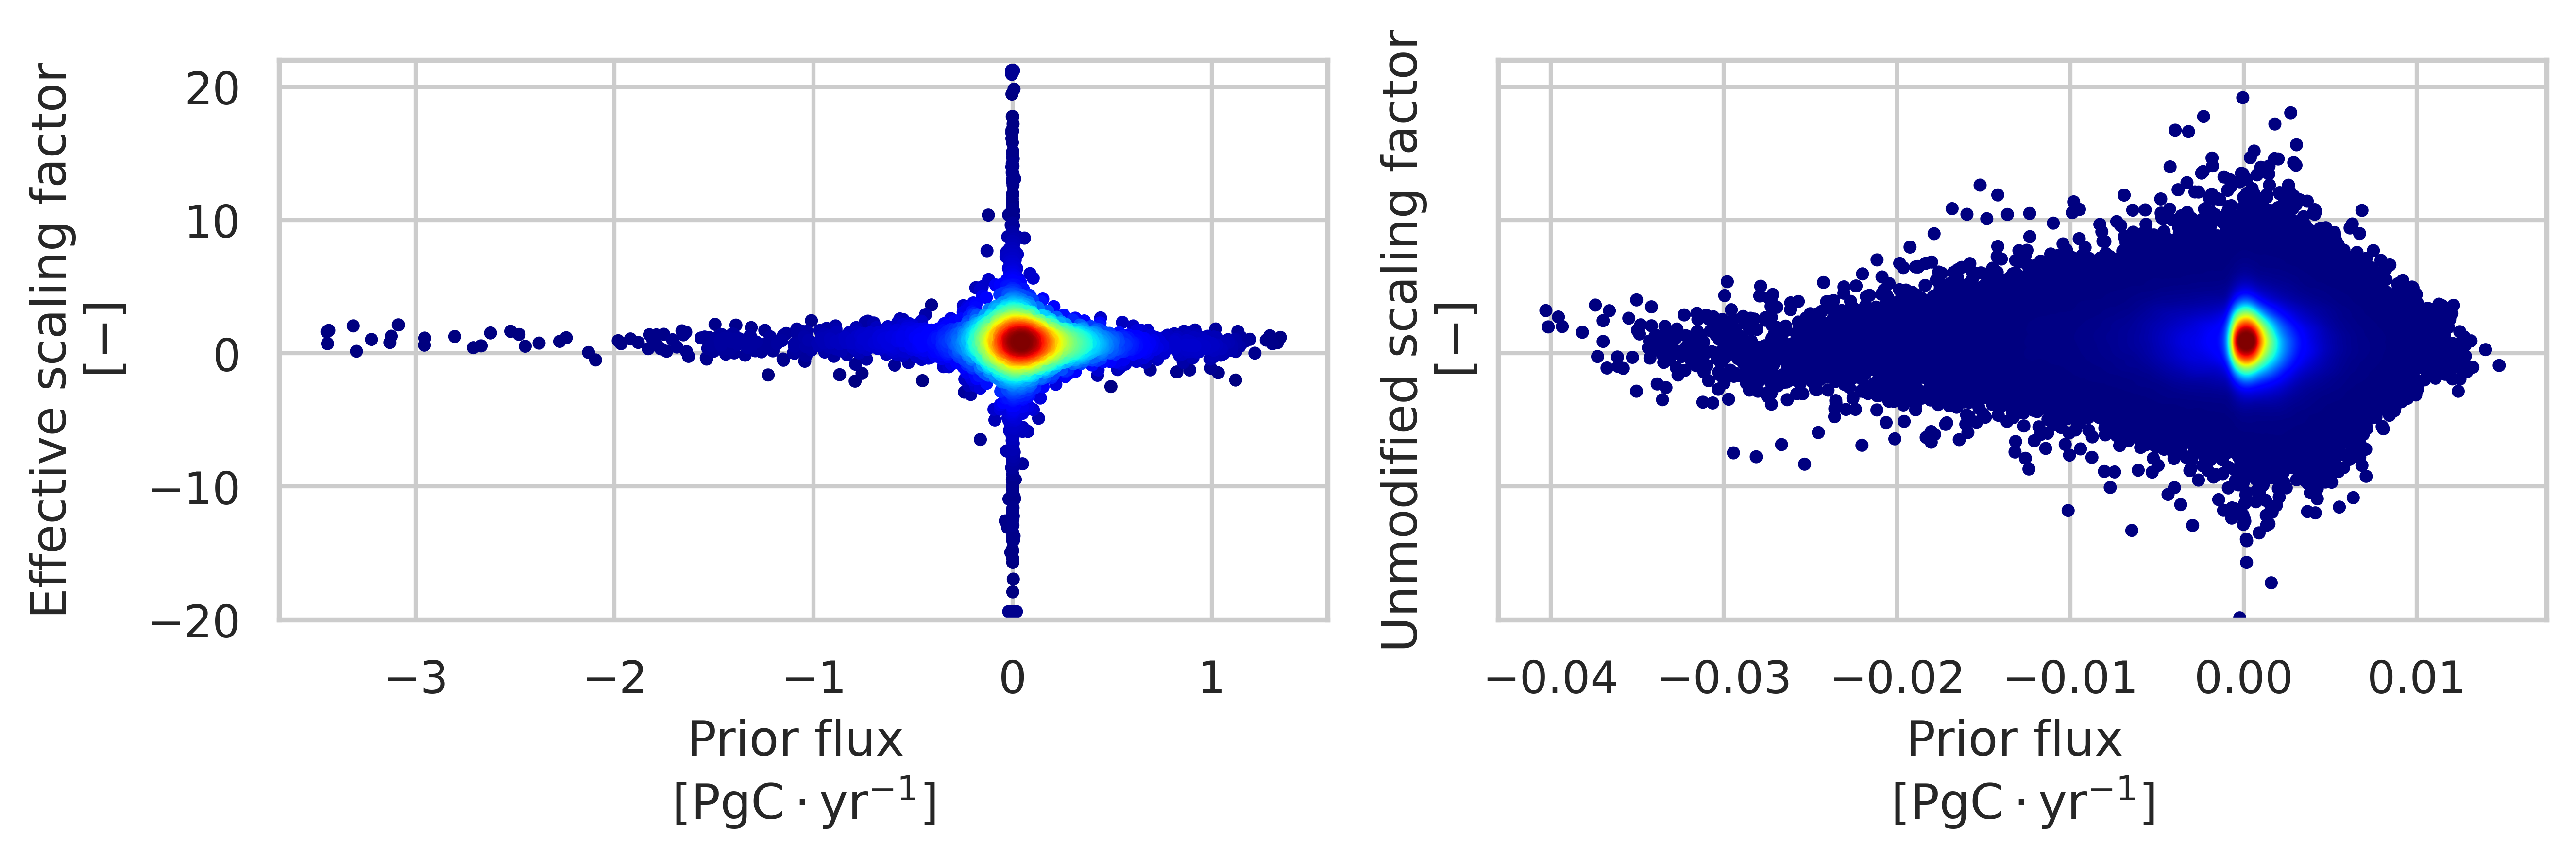

In [17]:
# Source: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

# ---------------------- First figure -------------------
with xr.open_dataset('./data_files/vars_per_eco_update.nc') as ds:
    remaining_vars = ds[[
                    'prior_flux_per_s', 'sf_per_eco']]

fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr

x = remaining_vars.prior_flux_per_s.isel(time=slice(0,52)).values.flatten()*fac
y = remaining_vars.sf_per_eco.isel(time=slice(0,52)).values.flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(1, 2, figsize=(9,3), sharey=True)
ax[0].scatter(x, y, c=z, s=5, cmap='jet')

ax[0].set_ylim(-20, 22)
ax[0].set_ylabel('Effective scaling factor\n'r'[$-$]')
ax[0].set_xlabel('Prior flux \n'r'[$\mathrm{PgC\cdot yr^{-1}}$]')

# ------------------ Second figure -------------------------
# Define which transcom regions should be included in the plot. Onl use those that are alo included in the effective scaling factor
included_trans_regions = [1.0, 2.0, 7.0, 8.0, 11.0] # corresponds to 'North American Boreal', 'North American Temperate', 'Eurasia Boreal', 'Eurasia Temperate', 'Europe'

# Use the region files to find the ecoregions within the selected transcom regions
with xr.open_dataset('./data_files/griddedNHparameters.nc') as ds:
    region_ds = ds[['regions', 'transcom_regions']]


needed_sv_elems = {}
for tc_region in included_trans_regions:
    needed_sv_elems[tc_region] = np.unique(region_ds.where(region_ds.transcom_regions == tc_region).regions.values)
needed_sv_elems = np.concatenate(list(needed_sv_elems.values()))


with xr.open_dataset('./data_files/weekly_flux.nc') as ds:
    flux_dat = ds.prior_flux.isel(time=slice(0,52)).assign_coords(regions=np.unique(region_ds.regions))

with xr.open_dataset('./data_files/weekly_sv.nc') as ds:
    sf_dat = ds.flux_multiplier_m.transpose().isel(time=slice(0,52)).assign_coords(regions=np.unique(region_ds.regions))


dropped_sv_elems = set(sf_dat.regions.values)-set(needed_sv_elems)

flux_dat = flux_dat.drop_sel(regions=list(dropped_sv_elems))
sf_dat = sf_dat.drop_sel(regions=list(dropped_sv_elems))

x = flux_dat.values.flatten()
y = sf_dat.values.flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax[1].scatter(x, y, c=z, s=5, cmap='jet')

ax[1].set_ylim(-20, 22)

ax[1].set_ylabel('Unmodified scaling factor\n'r'[$-$]')
ax[1].set_xlabel('Prior flux \n'r'[$\mathrm{PgC\cdot yr^{-1}}$]')

plt.tight_layout()
plt.savefig('../figures/corr_prior_flux_(e)sf.png')
#
plt.savefig('../figures/corr_prior_flux_(e)sf.pdf')
plt.show()

## 9.4 - 9.5
These plots are created in the `./SARIMAX.ipynb` notebook